# Random Variable Generator

Lets consider a density function $f$. We want to create $$X : \mathcal{B}(\mathbb{R}) \longrightarrow [b_{inf}, b_{sup}]$$ such as $$f(x) = p_X(x)$$ Or in other words :


$$\mathbb {P} (a\leqslant X\leqslant b)=\int _{a}^{b}f(t)\,\mathrm {d} t$$


The class RandomVariableGenerator allows the user to create a random variable where he can sample it from any function.
The user gives the function and the bounds of the function. The code will normalize it to make this function a density function, the you can create the milestone list. The more the milestone list is big, the more precise will be the sampled number.

For instance, if you create a binary tre of depth 2, the milestone list will have the length 2^2 + 1 = 5 so you sampled number can take only 5 numbers. But if you do that with a tree of depth 1, you will get a milestone list of length 2^16 + 1 = 65537. So your sample can take 65537 different values, which is a way better.

In [167]:
import numpy as np

import matplotlib.pylab as plt
import scipy.integrate
import time
from tqdm import tqdm
import multiprocessing

x-Barycenter of the function: -0.24


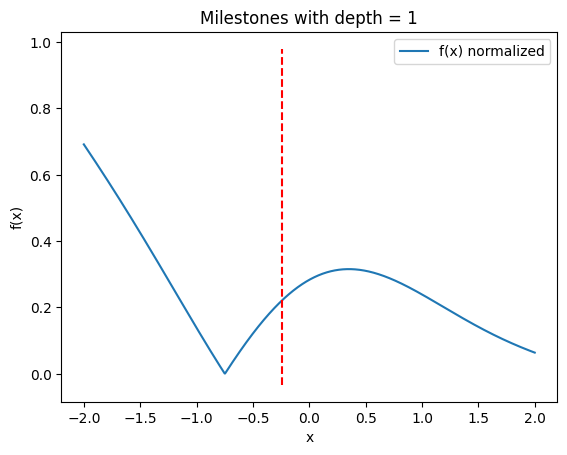

 75%|███████▌  | 3/4 [00:00<00:00, 236.16it/s]


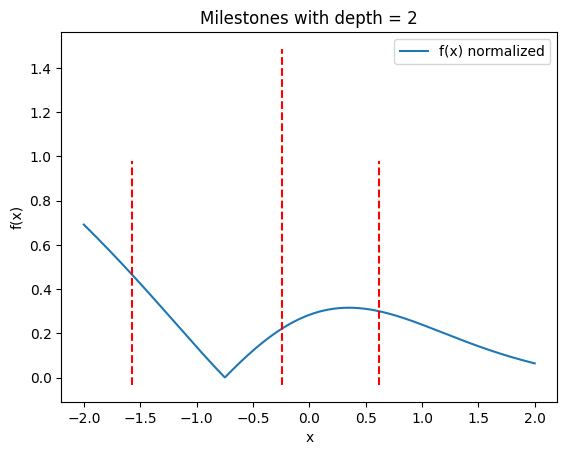

 88%|████████▊ | 7/8 [00:00<00:00, 762.36it/s]


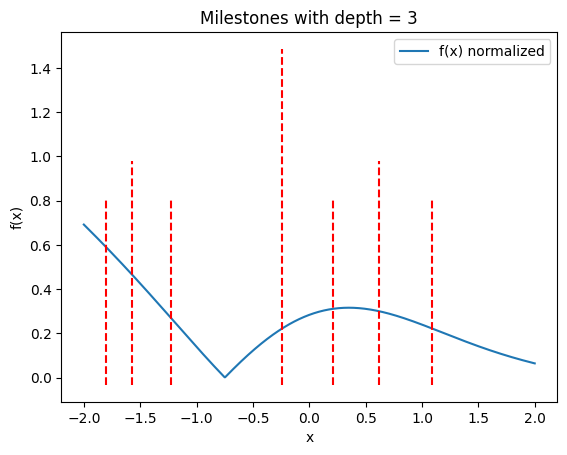

In [168]:
class RandomVariableGenerator:
    def __init__(self, f: callable, b_inf:float=-1, b_sup:float = 1):
        self.b_inf = b_inf
        self.b_sup = b_sup
        self.list_milestones = []
        integral_f = scipy.integrate.quad(f,b_inf,b_sup)[0]
        self.f = lambda x:f(x)/integral_f
    
    def plot_function(self):
        x_values = np.linspace(b_inf, b_sup, 1000)
        y_values = self.f(x_values)
        plt.plot(x_values, y_values, label='f(x) normalized')
        plt.title('Function')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.legend()
        self.vertical_bounds = plt.ylim()
    
    def add_vertical_line(self, x, importance:float=1):
        assert self.vertical_bounds != None, "Please plot the function before plotting vertical lines."
        plt.vlines(x=x, ymin=self.vertical_bounds[0], ymax=(self.vertical_bounds[1]-self.vertical_bounds[0])*(importance+1)/1.5+self.vertical_bounds[0], color='r', linestyle='--')
    
    def get_barycenter(self, inf, sup, prec = None):
        F = lambda x: scipy.integrate.quad(self.f,inf,x)[0] - scipy.integrate.quad(self.f,x,sup)[0]
        prec = prec if prec != None else 4
        point = (inf+sup)/2
        for _ in range(prec):
            point = point - F(point)/(2*self.f(point))
        return point, F(point)
    
    def build_milestones(self, depth:int = 5, plot:bool = False):
        max_depth = depth
        b_inf, b_sup = self.b_inf, self.b_sup
        list_milestones = np.array([b_inf, b_sup])
        with tqdm(total=2**depth, dynamic_ncols=True) as pbar:
            for depth in (range(max_depth)):
                slicings = self.get_slicings(list_milestones)
                new_slicings = np.zeros(len(slicings))
                for index, item in enumerate(slicings):
                    inf, sup = item[0], item[1]
                    new_slicing = self.get_barycenter(inf, sup)[0]
                    new_slicings[index] = new_slicing
                    if plot:
                        self.add_vertical_line(new_slicing,importance=2/(depth+1))
                    pbar.update(1)
                list_milestones = np.sort(np.concatenate([list_milestones,new_slicings]))
        self.list_milestones = list_milestones

    @staticmethod
    def get_slicings(list_):
        return [[list_[i], list_[i+1]] for i in range(len(list_)-1)]
    
    def get_sample(self, var=None):
        assert len(self.list_milestones) != 0, "Cannot create a sample because no tree was built (no milestone list)"
        length_list = len(self.list_milestones)
        right = length_list
        left = 0
        continue_loop = True
        while continue_loop:
            choice = np.random.randint(0,2)
            if choice:
                left = (right+left)//2
            else :
                right = (right+left)//2
            if left == right:
                continue_loop = False
        return self.list_milestones[left]
    

        
f = lambda x : abs(-np.exp(-x**2/2) + 0.1*(x-2)**2)
b_inf, b_sup = -2, 2
rvg = RandomVariableGenerator(f,b_inf,b_sup)
barycenter, error = rvg.get_barycenter(b_inf,b_sup)
print('x-Barycenter of the function:', np.round(barycenter,2))
rvg.plot_function()
plt.title('Milestones with depth = 1')
rvg.add_vertical_line(barycenter)
plt.show()

depth=2
rvg.plot_function()
rvg.build_milestones(depth=depth, plot=True)
plt.title('Milestones with depth = '+ str(depth))
plt.show()

depth=3
rvg.plot_function()
rvg.build_milestones(depth=depth, plot=True)
plt.title('Milestones with depth = '+ str(depth))
plt.show()

In [169]:
depth = 17
print('Building the milesone list with depth =', depth)
rvg.build_milestones(depth=depth,plot=False)
print('Length of the milestone list:', len(rvg.list_milestones))

Building the milesone list with depth = 17


100%|█████████▉| 131071/131072 [00:21<00:00, 6233.24it/s]

Length of the milestone list: 131073


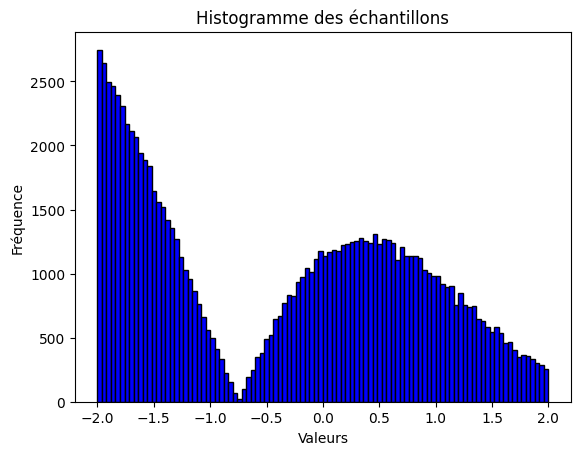

In [171]:

plt.hist([rvg.get_sample() for _ in range(int(1e5))], bins=100, color='blue', edgecolor='black')

# Ajout de labels et d'un titre
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Histogramme des échantillons')

# Affichage de l'histogramme
plt.show()